# **Supervised Learning Problem Description:**
###
In this project, we aim to build a supervised machine learning model to detect anomalous price behavior in the SPDR S\&P 500 ETF Trust (ticker: SPY), a widely traded exchange-traded fund that tracks the performance of the S\&P 500 index. Detecting anomalies in financial time series can be critical for identifying irregular market behavior, sudden volatility, or potential trading opportunities.

We define an anomaly as a price movement that exceeds a predefined threshold based on historical volatility. Using labeled data generated from historical SPY price and volume data, the model will classify each trading day as either **"anomalous"** or **"normal"**, based on whether future returns deviate significantly from historical patterns.

This binary classification task allows us to experiment with supervised learning methods, using engineered features from technical indicators and price history to train the model. The ultimate goal is to understand how well a machine learning model can predict unusual stock behavior, and whether these insights could be used to support decision-making in trading strategies.


## Labeling our data for Supervised Learning Approach

We download historical SPY data from Yahoo Finance and create labels for a supervised anomaly detection task. We define an anomaly as any price movement greater than 5% (up or down) within the next 3 trading days. These labels will be used to train a binary classification model that predicts whether an anomalous movement is likely to occur based on current market conditions.

In [1]:
import yfinance as yf
import pandas as pd

df = yf.download("SPY", start="2001-01-01", end="2025-06-30")
df['Return'] = df['Close'].pct_change()

df['Future_Return'] = (df['Close'].shift(-3) - df['Close']) / df['Close']

df['Anomaly_Label'] = df['Future_Return'].apply(lambda x: 1 if abs(x) > 0.05 else 0)

df.dropna(inplace=True)
print(df['Anomaly_Label'].value_counts())

/var/folders/2c/qygskv157kb4mktd2s8gc7lw0000gn/T/ipykernel_20838/755440460.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("SPY", start="2001-01-01", end="2025-06-30")
[*********************100%***********************]  1 of 1 completed

Anomaly_Label
0    5998
1     156
Name: count, dtype: int64


# Preview Dataset

In [2]:
print(df.shape)
df.head()

(6154, 8)


Price,Close,High,Low,Open,Volume,Return,Future_Return,Anomaly_Label
Ticker,SPY,SPY,SPY,SPY,SPY,,,
Date,,,,,,,,
2001-01-03,86.429306,87.069523,81.727712,82.147854,19431600,0.048035,-0.035648,0
2001-01-04,85.498993,86.729410,85.148874,86.389295,9219000,-0.010764,-0.027729,0
2001-01-05,82.708031,85.548994,82.708031,85.448960,12911400,-0.032643,0.022738,0
2001-01-08,83.348267,83.348267,81.747724,83.148199,6625300,0.007741,0.015842,0
2001-01-09,83.128174,84.188533,82.858082,83.898435,5702400,-0.002641,0.016606,0


# EDA Procedure

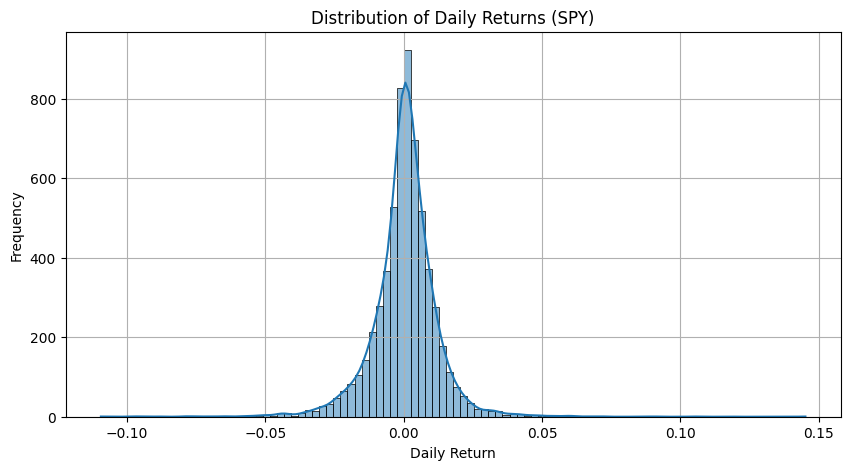

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df['Return'], bins=100, kde=True)
plt.title("Distribution of Daily Returns (SPY)")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


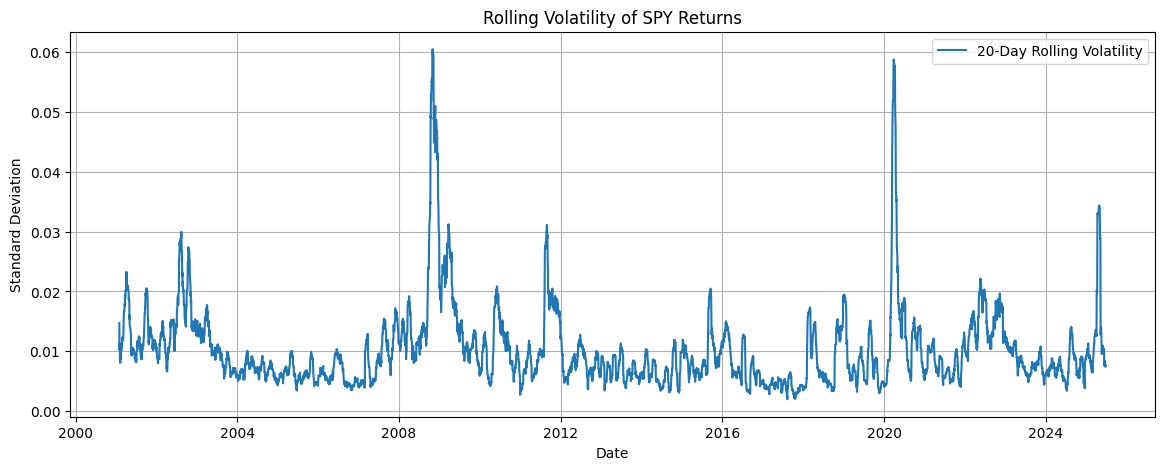

In [4]:
df['Rolling_Std'] = df['Return'].rolling(window=20).std()

plt.figure(figsize=(14, 5))
plt.plot(df['Rolling_Std'], label='20-Day Rolling Volatility')
plt.title("Rolling Volatility of SPY Returns")
plt.xlabel("Date")
plt.ylabel("Standard Deviation")
plt.grid(True)
plt.legend()
plt.show()


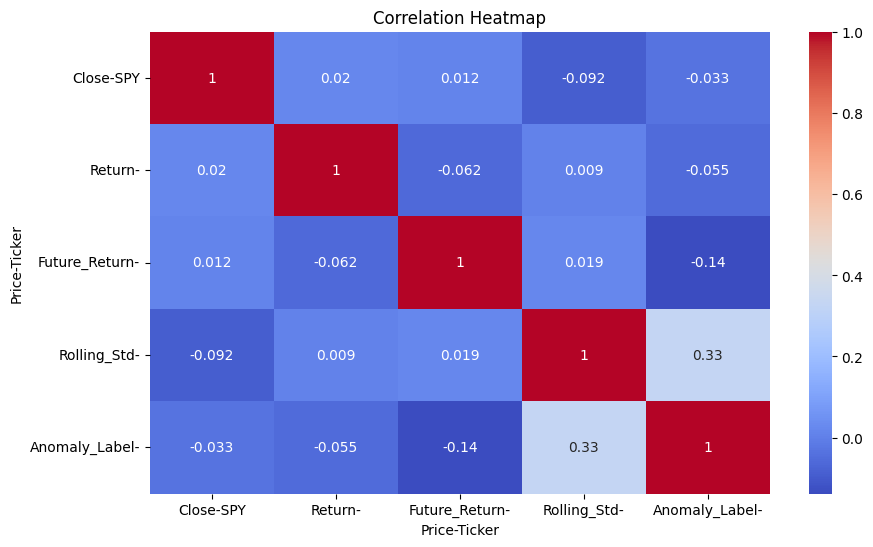

In [5]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[['Close', 'Return', 'Future_Return', 'Rolling_Std', 'Anomaly_Label']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [6]:
grouped = df.groupby('Anomaly_Label')

print("Return stats:")
display(grouped['Return'].describe())

print("Future Return stats:")
display(grouped['Future_Return'].describe())

print("Rolling Std stats:")
display(grouped['Rolling_Std'].describe())


Return stats:


,count,mean,std,min,25%,50%,75%,max
Anomaly_Label,,,,,,,,
0,5998.0,0.000507,0.011203,-0.109424,-0.004215,0.000730,0.005929,0.116855
1,156.0,-0.003781,0.031810,-0.098448,-0.020984,-0.003502,0.009889,0.145198


Future Return stats:


,count,mean,std,min,25%,50%,75%,max
Anomaly_Label,,,,,,,,
0,5998.0,0.001593,0.015901,-0.049166,-0.007254,0.002556,0.011134,0.049499
1,156.0,-0.015607,0.072528,-0.133881,-0.068519,-0.053178,0.056296,0.171563


Rolling Std stats:


,count,mean,std,min,25%,50%,75%,max
Anomaly_Label,,,,,,,,
0,5979.0,0.009820,0.006057,0.002010,0.006014,0.008435,0.011863,0.060422
1,156.0,0.024195,0.014754,0.004001,0.013223,0.019249,0.028736,0.059452


Select Features

# Select Features

In [7]:
features = [
    'Return',
    'Rolling_Std',
    'Close',
    'Volume'
]

X = df[features]
y = df['Anomaly_Label']

X = X.dropna()
y = y.loc[X.index] 

In [8]:
# Train-Test Split (No Data Leakage!)

In [9]:
from sklearn.model_selection import train_test_split

# Time-aware split: don’t randomly shuffle financial time series
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


In [10]:
# Train Baseline Models
X.isnull().sum()

Price        Ticker
Return                 0
Rolling_Std            0
Close        SPY       0
Volume       SPY       0
dtype: int64

In [11]:
## Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)


LogisticRegression()

In [13]:
## Logistic Regression Evaluation

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

print("Logistic Regression")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))


Logistic Regression
[[1187    0]
 [  25    0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1187
           1       0.00      0.00      0.00        25

    accuracy                           0.98      1212
   macro avg       0.49      0.50      0.49      1212
weighted avg       0.96      0.98      0.97      1212

ROC-AUC: 0.6197472620050548


/Users/ck9l/Projects/stock-anomalies/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ck9l/Projects/stock-anomalies/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ck9l/Projects/stock-anomalies/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [15]:
## ROC CURVE for Logistic Regression

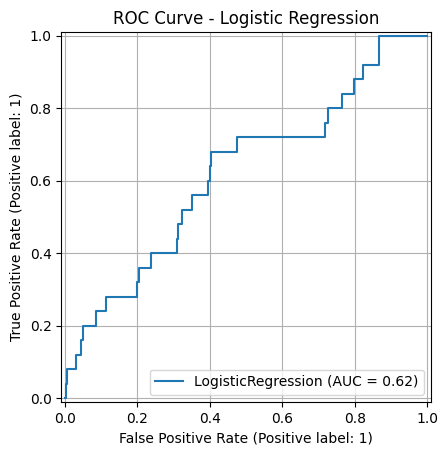

In [16]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(lr, X_test, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.grid(True)
plt.show()


In [17]:
# Random Forest 

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=54)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=54)

In [19]:
# Random Forest Evaluation 

In [20]:
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))


Random Forest
[[888 299]
 [  8  17]]
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      1187
           1       0.05      0.68      0.10        25

    accuracy                           0.75      1212
   macro avg       0.52      0.71      0.48      1212
weighted avg       0.97      0.75      0.84      1212

ROC-AUC: 0.722190395956192


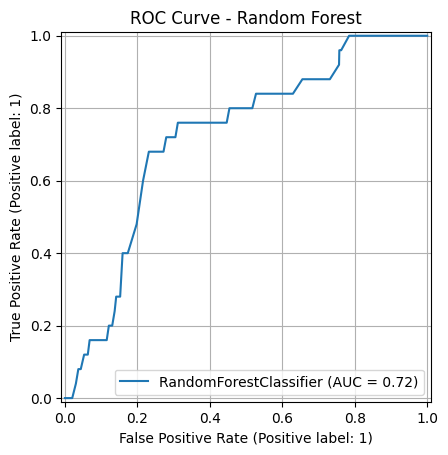

In [21]:
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.grid(True)
plt.show()


# Weak ROC results so we are adding more features / model complexity

# New Features 

In [22]:
import numpy as np
import pandas as pd

# Lag features
df['Lag_1'] = df['Return'].shift(1)
df['Lag_3'] = df['Return'].shift(3)

# Exponential moving averages
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

# RSI (Relative Strength Index)
delta = df['Close'].diff()
gain = np.where(delta > 0, delta, 0).flatten()
loss = np.where(delta < 0, -delta, 0).flatten()

roll_up = pd.Series(gain, index=df.index).rolling(window=14).mean()
roll_down = pd.Series(loss, index=df.index).rolling(window=14).mean()
RS = roll_up / roll_down
df['RSI_14'] = 100.0 - (100.0 / (1.0 + RS))

# MACD and signal line
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

# Price range (approximate using absolute return diff)
df['Price_Range'] = df['Close'].pct_change().abs().rolling(2).sum()

# Drop any resulting NaNs from rolling/windowed features
df.dropna(inplace=True)


In [23]:
features = [
    'Return', 'Rolling_Std', 'Close', 'Volume',
    'Lag_1', 'Lag_3',
    'EMA_10', 'EMA_20',
    'RSI_14',
    'MACD', 'MACD_Signal', 'MACD_Hist',
    'Price_Range'
]

X = df[features]
y = df['Anomaly_Label']

X = X.dropna()
y = y.loc[X.index]


## LOGISTIC REGRSSION 2.0

In [24]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

## Logistic Regression Evaluation 2.0

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

print("Logistic Regression")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))


Logistic Regression
[[1187    0]
 [  25    0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1187
           1       0.00      0.00      0.00        25

    accuracy                           0.98      1212
   macro avg       0.49      0.50      0.49      1212
weighted avg       0.96      0.98      0.97      1212

ROC-AUC: 0.6197472620050548


/Users/ck9l/Projects/stock-anomalies/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ck9l/Projects/stock-anomalies/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ck9l/Projects/stock-anomalies/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

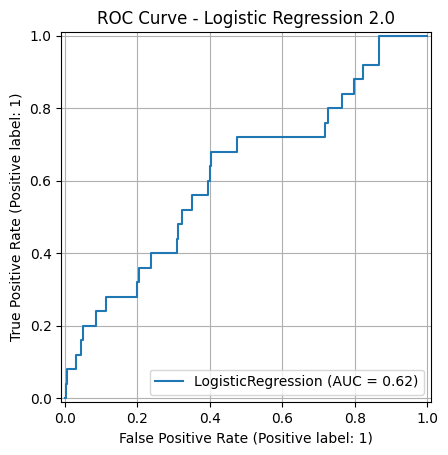

In [26]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(lr, X_test, y_test)
plt.title("ROC Curve - Logistic Regression 2.0")
plt.grid(True)
plt.show()

## Our findings indicate the logistic regression is a poor model to utilize and we will continue on with only random forest

##

#### Our findings Indicate that Logistic Regression is not a good model to utilize for stock anomaly detection and we will only be using random forest going forward in this analysis

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=54)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=54)

In [28]:
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

Random Forest
[[888 299]
 [  8  17]]
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      1187
           1       0.05      0.68      0.10        25

    accuracy                           0.75      1212
   macro avg       0.52      0.71      0.48      1212
weighted avg       0.97      0.75      0.84      1212

ROC-AUC: 0.722190395956192


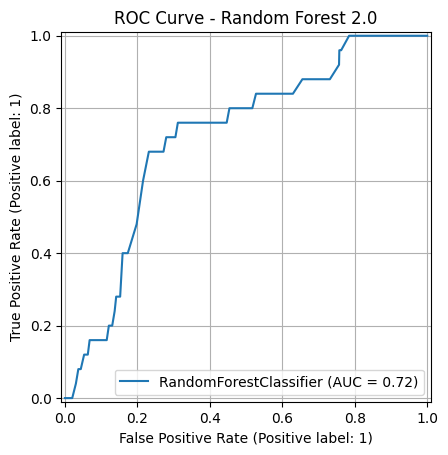

In [29]:
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("ROC Curve - Random Forest 2.0")
plt.grid(True)
plt.show()


In [30]:
##

In [31]:
## Random Forest is doing slightly better - Now lets work on improving it 

Model Pruning and Tuning Strategy

Improving Random Forest with Pruning and Tuning
Our Random Forest model shows promising recall on anomalies (class 1), but suffers from a high false positive rate, reducing overall precision and usability. To improve this, we use model pruning and hyperparameter tuning to reduce overfitting and better generalize to unseen data.

1. Pruning Random Forest

Random Forest is composed of many decision trees. Deep trees can memorize training data and overfit. We limit the tree complexity using parameters like:

max_depth: Maximum depth of each tree
min_samples_split: Minimum samples required to split an internal node
min_samples_leaf: Minimum samples required to be at a leaf node

2. Hyperparameter Tuning

We'll use GridSearchCV to find the best combination of pruning parameters by testing multiple configurations using cross-validation. The best model will be selected based on F1 score, which balances precision and recall.

3. Handling Class Imbalance

We also set class_weight='balanced' to ensure the model gives fair importance to rare anomaly cases.

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
}


In [33]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    verbose=2,
    n_jobs=-1
)


In [34]:
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

print("Best parameters found:", grid_search.best_params_)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters found: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


Tuned Random Forest Results
[[972 215]
 [ 11  14]]
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      1187
           1       0.06      0.56      0.11        25

    accuracy                           0.81      1212
   macro avg       0.52      0.69      0.50      1212
weighted avg       0.97      0.81      0.88      1212

ROC-AUC: 0.7903454085930918


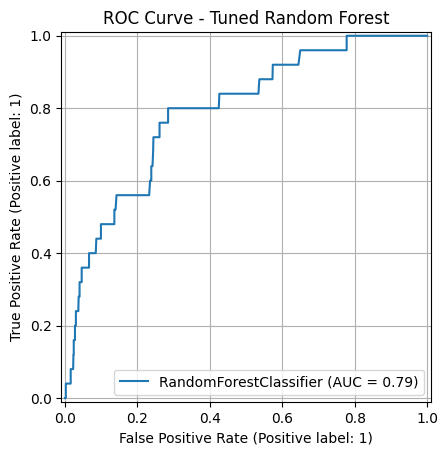

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

y_pred_best = best_rf.predict(X_test)
y_proba_best = best_rf.predict_proba(X_test)[:, 1]

print("Tuned Random Forest Results")
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_best))

RocCurveDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("ROC Curve - Tuned Random Forest")
plt.grid(True)
plt.show()


In [36]:
import pandas as pd

# 1. Load and clean sentiment data
df_sentiment = pd.read_csv('/Users/ck9l/Downloads/news_sentiment_data.csv', parse_dates=['date'])
df_sentiment = df_sentiment[['date', 'News Sentiment']]
df_sentiment = df_sentiment[
    (df_sentiment['date'] >= '2001-01-01') &
    (df_sentiment['date'] <= '2025-06-30')
]

# 2. Reset index of df and make sure 'Date' is a proper column
if isinstance(df.columns, pd.MultiIndex):
    df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]

if 'Date' not in df.columns:
    df = df.reset_index()

# 3. Ensure matching column names
df_sentiment.rename(columns={'date': 'Date'}, inplace=True)

# 4. Merge cleanly
df = df.merge(df_sentiment, on='Date', how='left')


/var/folders/2c/qygskv157kb4mktd2s8gc7lw0000gn/T/ipykernel_20838/1265814376.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_sentiment = pd.read_csv('/Users/ck9l/Downloads/news_sentiment_data.csv', parse_dates=['date'])


In [37]:
df.columns


Index(['Date', 'Close_SPY', 'High_SPY', 'Low_SPY', 'Open_SPY', 'Volume_SPY',
       'Return_', 'Future_Return_', 'Anomaly_Label_', 'Rolling_Std_', 'Lag_1_',
       'Lag_3_', 'EMA_10_', 'EMA_20_', 'RSI_14_', 'MACD_', 'MACD_Signal_',
       'MACD_Hist_', 'Price_Range_', 'News Sentiment'],
      dtype='object')

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

features = [
    'Return_', 'Rolling_Std_', 'Close_SPY', 'Volume_SPY',
    'Lag_1_', 'Lag_3_', 'EMA_10_', 'EMA_20_',
    'RSI_14_', 'MACD_', 'MACD_Signal_', 'MACD_Hist_',
    'Price_Range_', 'News Sentiment'
]


# 2. Prepare X and y
X = df[features].dropna()
y = df.loc[X.index, 'Anomaly_Label_']

# 3. Train-test split
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# 4. Train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    random_state=42,
    class_weight='balanced'  # Helps with class imbalance
)
rf.fit(X_train, y_train)

# 5. Predictions
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

# 6. Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


[[1056  146]
 [  18    7]]
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      1202
           1       0.05      0.28      0.08        25

    accuracy                           0.87      1227
   macro avg       0.51      0.58      0.50      1227
weighted avg       0.96      0.87      0.91      1227

ROC-AUC: 0.5232279534109817


In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Set up param grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'class_weight': ['balanced']
}

# Create base model
rf = RandomForestClassifier(random_state=42)

# Grid search
grid = GridSearchCV(estimator=rf, param_grid=param_grid,
                    cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# Best model
best_rf = grid.best_estimator_

# Predict
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

# Evaluate
print(f"Best params: {grid.best_params_}\n")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best params: {'class_weight': 'balanced', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}

              precision    recall  f1-score   support

           0       0.99      0.82      0.90      1202
           1       0.06      0.52      0.10        25

    accuracy                           0.81      1227
   macro avg       0.52      0.67      0.50      1227
weighted avg       0.97      0.81      0.88      1227

ROC-AUC: 0.7375374376039933


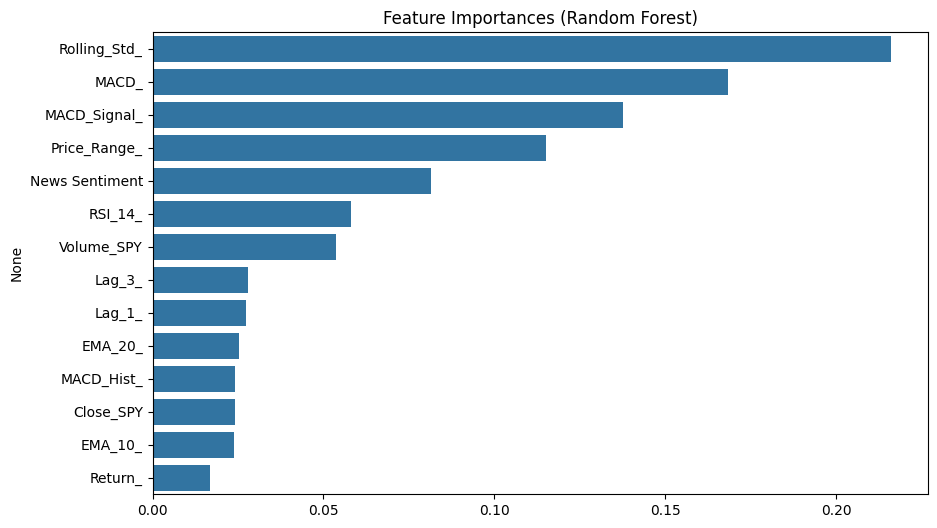

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = pd.Series(best_rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Feature Importances (Random Forest)")
plt.show()


In [41]:
# 1. Quantile bucket News Sentiment into 5 categories (1 = lowest sentiment, 5 = highest)
df['Sentiment_Bucket'] = pd.qcut(df['News Sentiment'], q=5, labels=[1, 2, 3, 4, 5]).astype(int)

# 2. Update feature set
if 'News Sentiment' in features:
    features.remove('News Sentiment')
if 'Sentiment_Bucket' not in features:
    features.append('Sentiment_Bucket')

# 3. Prepare X and y
X = df[features].dropna()
y = df.loc[X.index, 'Anomaly_Label_']

# 4. Train-test split
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


[[1200    2]
 [  24    1]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1202
           1       0.33      0.04      0.07        25

    accuracy                           0.98      1227
   macro avg       0.66      0.52      0.53      1227
weighted avg       0.97      0.98      0.97      1227

ROC-AUC: 0.4744093178036605


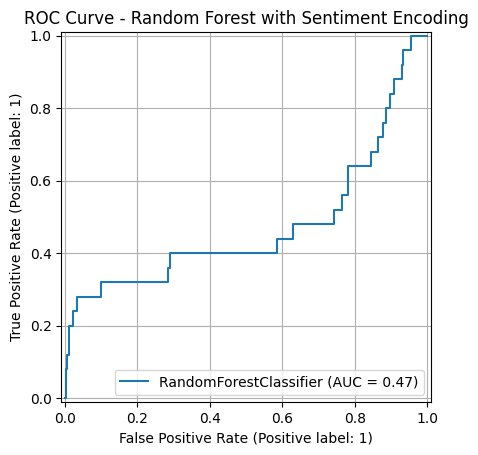

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# 1. Train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_leaf=5,
    random_state=42
)
rf.fit(X_train, y_train)

# 2. Predictions
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

# 3. Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=2))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

# 4. Plot ROC Curve
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("ROC Curve - Random Forest with Sentiment Encoding")
plt.grid(True)
plt.show()


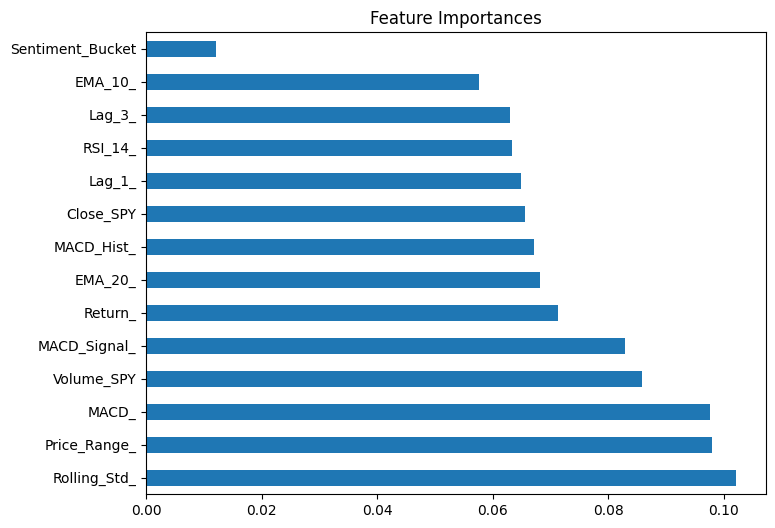

In [43]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

# Train basic model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

# Plot top features
importances.plot(kind='barh', figsize=(8, 6))
plt.title("Feature Importances")
plt.show()



In [44]:
# Keep top N features (try 8–12)
top_features = importances.head(10).index.tolist()

# Rebuild data
X_train_pruned = X_train[top_features]
X_test_pruned = X_test[top_features]


In [45]:
# Retrain with pruned features
rf_pruned = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)
rf_pruned.fit(X_train_pruned, y_train)

# Predict and evaluate
y_pred = rf_pruned.predict(X_test_pruned)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.82      0.89      1202
           1       0.02      0.20      0.04        25

    accuracy                           0.81      1227
   macro avg       0.50      0.51      0.47      1227
weighted avg       0.96      0.81      0.87      1227



In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

# 1. Resample to balance classes
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# 2. Split the balanced dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# 3. Define a conservative hyperparameter grid to avoid overfitting
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt'],
    'class_weight': ['balanced_subsample']
}

# 4. Grid search with cross-validation
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)

# 5. Best estimator
best_rf = grid_search.best_estimator_

# 6. Evaluate on test set
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/ck9l/Projects/stock-anomalies/venv/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/ck9l/Projects/stock-anomalies/venv/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Best Parameters: {'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.77      0.84      0.81        32
           1       0.82      0.74      0.78        31

    accuracy                           0.79        63
   macro avg       0.80      0.79      0.79        63
weighted avg       0.80      0.79      0.79        63

ROC-AUC: 0.8538306451612903
